<a href="https://colab.research.google.com/github/prithvijaunjale/NLP/blob/master/skills_ner_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Named Entity Recognition with BERT**





*For inference:
* Run the 'Imports' snippet.
* Mention your ```drive_path```.
* Set ```LOAD_DATA = True```.
* Run the 'Inference' snippet.




## Imports

In [ ]:
! pip3 install transformers seqeval

     |████████████████████████████████| 675kB 10.7MB/s 
     |████████████████████████████████| 3.8MB 48.7MB/s 
     |████████████████████████████████| 890kB 50.7MB/s 
     |████████████████████████████████| 1.1MB 48.5MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=abc24e1746522d4c7d5236a390b406f09f468c09e31945a5e67623d3b04d3a14
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=34e3d4c6f8d946b678e5696ae166806ed57de33bf5f02fae182f698c19c83757
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built seqeval sacremoses


In [ ]:
import pandas as pd
import numpy as np
import csv
import nltk
import pickle
from pprint import pprint
import re
import json
from tqdm.notebook import tqdm
nltk.download('punkt')

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW

import os
from tqdm import trange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

drive_path = 'drive/My Drive/hackathons/ibm_hack_2020/ner_bert/'
LOAD_DATA = True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


## Data Preprocessing

### Soft skills data

In [ ]:
! git clone https://github.com/muzaluisa/soft-skill-matching.git

Cloning into 'soft-skill-matching'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 58 (delta 3), reused 0 (delta 0), pack-reused 45
Unpacking objects: 100% (58/58), done.


In [ ]:
with open('soft-skill-matching/datasets/job_test.csv', 'r') as c:
    csv_read = csv.reader(c)
    job_test = []
    for row in csv_read:
        if len(row) == 3:
            job_test.append(row)

with open('soft-skill-matching/datasets/job_test.csv', 'w') as c:
    csv_write = csv.writer(c)
    for row in job_test:
        csv_write.writerow(row)

In [ ]:
job = pd.read_csv('soft-skill-matching/datasets/job_train.csv')
job = job.append(pd.read_csv('soft-skill-matching/datasets/job_test.csv'))
cv = pd.read_csv('soft-skill-matching/datasets/cv_test.csv')

In [ ]:
job.head()

,is_soft_skill,soft_skill,context
0,1,able to multitask,excellent organisational skill and xxx xxx xxx
1,1,team member,look for to work a a xxx xxx with hilton hotel s
2,1,verbal communication skills,"to detail and accuracy , fantastic write and x..."
3,0,dynamic,for an experience and dedicate ict manager to ...
4,0,dynamic,"this be a unique , xxx and challenge role that..."


In [ ]:
cv.head()

,is_soft_skill,sentence
0,0.666667,"Strong analytical, planning and process <b>man..."
1,1.000000,"I am a <b>reliable</b>, hard working and highl..."
2,1.000000,"I am extremely determined, self-<b>motivated</..."
3,1.000000,"Self-motivated, well <b>organized</b> and with..."
4,1.000000,"I am an extremely <b>reliable</b>, trustworthy..."


In [ ]:
def find_all_indexes(input_str, search_str):
    l1 = []
    length = len(input_str)
    index = 0
    while index < length:
        i = input_str.find(search_str, index)
        if i == -1:
            return l1
        l1.append(i)
        index = i + 1
    return l1

In [ ]:
# cleaning the 'job' dataframe

sentences = []
tokens = []
tags = []

sent_cnt = 0
for sent, soft_skill in zip(job['context'], job['soft_skill']):
    xxx_cnt = find_all_indexes(sent, 'xxx')
    xxx_cnt = len(xxx_cnt)

    sent_cnt += 1
    i = 0
    if len(soft_skill.split()) == xxx_cnt:
        for word in nltk.word_tokenize(sent):
            sentences.append('Sentence: ' + str(sent_cnt))
            if word == 'xxx':
                tokens.append(soft_skill.split()[i])
                if i == 0:
                    tags.append('B-softskill')
                else:
                    tags.append('I-softskill')
                i += 1
            else:
                tokens.append(word)
                tags.append('O')

len(sentences), len(tokens), len(tags)

(105920, 105920, 105920)

In [ ]:
# cleaning the 'cv' dataframe

for sent in cv['sentence']:
    start_pos = sent.find('<b>')
    end_pos = sent.find('</b>') - len('</b>') + 1

    sent_cleaned = sent.replace('<b>', '').replace('</b>', '')
    soft_skill_tokens = sent_cleaned[start_pos: end_pos].split()
    sent_tokens = nltk.word_tokenize(sent_cleaned)

    sent_cnt += 1

    n_token = 0
    for token in sent_tokens:
        sentences.append('Sentence: ' + str(sent_cnt))
        tokens.append(token)
        if token in soft_skill_tokens:
            n_token += 1
            if n_token == 1:
                tags.append('B-softskill')
            else:
                tags.append('I-softskill')
        else:
            tags.append('O')

len(sentences), len(tokens), len(tags)

(118073, 118073, 118073)

### Hard skills data

In [ ]:
with open('drive/My Drive/hackathons/ibm_hack_2020/data/dataframe_bert.txt', 'rb') as p:
    scraped_df = pickle.load(p)
scraped_df['Label'].value_counts()

skill              19705
others             13246
job description     9718
title               4977
date_range          4969
name                1676
degree              1523
Name: Label, dtype: int64

In [ ]:
hard_skills = scraped_df.loc[scraped_df['Label'] == 'skill']['Sentence'].to_list()
hard_skills = set(hard_skills)

li = []
for item in hard_skills:
    if '\n' in item:
        split = item.split('\n', 1)[0]
        li += [x .strip() for x in split.strip('\n').split(',')]
    else:
        li += [x.strip() for x in item.split(',')]

hard_skills = [x for x in set(li) if len(x) > 1]
hard_skills = set(hard_skills)
len(hard_skills)

3067

In [ ]:
job_d = scraped_df.loc[scraped_df['Label'] == 'job description']
job_d_sentences = []

for desc in job_d['Sentence']:
    # remove special characters
    desc = re.sub("[^a-zA-Z0-9\s.,?!'()]", ' ', desc)
    # pad punctuations
    desc = re.sub('([.,!?()])', r' \1 ', desc)
    desc = ' '.join([word for word in desc.split() if 'www' not in word and
                       'http' not in word and
                       '.com' not in word and
                       '.in' not in word])
    desc = desc.strip('\n').strip('\t')

    sents = nltk.sent_tokenize(desc)
    sents = [x.strip() for x in sents if len(x.split()) > 2 and 'see more' not in x]

    job_d_sentences += sents

job_d_sentences = set(job_d_sentences)
print('Total no. of sentences:', len(job_d_sentences))

found_cnt = 0
for sent in tqdm(job_d_sentences):
    sent_cnt += 1
    temp_sent = sent

    # find all hard skills present
    temp_found = set()
    for hard_skill in hard_skills:
        if hard_skill in sent:
            temp_found.add(hard_skill)
    if len(temp_found) == 0:
        continue

    # count
    found_cnt += 1

    # cleaning | e.g. remove 'Marketing' if 'Digital Marketing' present.
    cleaned = set()
    if len(temp_found) > 1:
        for item1 in temp_found:
            flag = False
            for item2 in temp_found:
                if item1 in item2 and item2 != item1:
                    flag = True
                    break
            if not flag:
                cleaned.add(item1)
    else:
        cleaned = temp_found.copy()

    # tag hard skill
    for hard_skill in cleaned:
        temp_sent = temp_sent.replace(hard_skill, '<b>' + hard_skill + '</b>')

    # create dataset
    for item in re.split('(<b>.*?</b>)', temp_sent):
        if '<b>' in item:
            for idx, tok in enumerate(item.strip('<b>').strip('</b>').strip().split()):
                sentences.append('Sentence: ' + str(sent_cnt))
                tokens.append(tok)
                if idx == 0:
                    tags.append('B-hardskill')
                else:
                    tags.append('I-hardskill')
        else:
            sentences.extend(['Sentence: ' + str(sent_cnt)] * len(item.strip().split()))
            tokens.extend(item.strip().split())
            tags.extend(['O'] * len(item.strip().split()))

print('No. of hard_skill_sentences:', found_cnt)
print('Total:', len(sentences))

Total no. of sentences: 8561



No. of hard_skill_sentences: 4853
Total: 233855


In [ ]:
with open('MoreHardskills.txt', 'rb') as p: 
    grouped_hs = pickle.load(p)

for group in grouped_hs['Sentence']:
    sent_cnt += 1
    for skill_idx, skill in enumerate(group.split(',')):
        for idx, tok in enumerate(skill.split()):
            sentences.append('Sentence: ' + str(sent_cnt))
            tokens.append(tok)
            if idx == 0:
                tags.append('B-hardskill')
            else:
                tags.append('I-hardskill')
        if skill_idx < len(group.split(',')):
            sentences.append('Sentence: ' + str(sent_cnt))
            tokens.append(',')
            tags.append('O')

print('Total:', len(sentences))

Total: 283986


In [ ]:
df_data = pd.DataFrame()
df_data['Sentence #'] = sentences
df_data['Word'] = tokens
df_data['Tag'] = tags

len(df_data)

283986

In [ ]:
df_data.head()

,Sentence #,Word,Tag
0,Sentence: 1,excellent,O
1,Sentence: 1,organisational,O
2,Sentence: 1,skill,O
3,Sentence: 1,and,O
4,Sentence: 1,able,B-softskill


In [ ]:
df_data = df_data.dropna()
print(len(df_data))
df_data.isnull().sum()

283986


Sentence #    0
Word          0
Tag           0
dtype: int64

### Load & Save dataset

In [ ]:
with open('drive/My Drive/hackathons/ibm_hack_2020/hs_ss_group_BIO_df.pkl', 'wb') as p:
    pickle.dump(df_data, p)

In [ ]:
with open('drive/My Drive/hackathons/ibm_hack_2020/hs_ss_group_BIO_df.pkl', 'rb') as p:
    df_data = pickle.load(p)
df_data.head()

,Sentence #,Word,Tag
0,Sentence: 1,excellent,O
1,Sentence: 1,organisational,O
2,Sentence: 1,skill,O
3,Sentence: 1,and,O
4,Sentence: 1,able,B-softskill


### Utils

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
# Get full document data struce
getter = SentenceGetter(df_data)

In [ ]:
# Get sentence data
sentences = [[tup[0] for tup in word_tag_tups] for word_tag_tups in getter.sentences]
sentences[0]

['excellent', 'organisational', 'skill', 'and', 'able', 'to', 'multitask']

In [ ]:
labels = [[s[1] for s in sent] for sent in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'B-softskill', 'I-softskill', 'I-softskill']


In [ ]:
tags_vals = set(df_data["Tag"].values)

# Add X  label for word piece support
# Add [CLS] and [SEP] as BERT need
tags_vals.add('X')
tags_vals.add('[CLS]')
tags_vals.add('[SEP]')
tags_vals.add('[PAD]')

tags_vals

{'B-hardskill',
 'B-softskill',
 'I-hardskill',
 'I-softskill',
 'O',
 'X',
 '[CLS]',
 '[PAD]',
 '[SEP]'}

In [ ]:
# tag2idx
tag2idx = {t: i for i, t in enumerate(tags_vals)}
tag2idx

{'B-hardskill': 6,
 'B-softskill': 1,
 'I-hardskill': 0,
 'I-softskill': 3,
 'O': 4,
 'X': 7,
 '[CLS]': 2,
 '[PAD]': 5,
 '[SEP]': 8}

In [ ]:
# idx2tag
idx2tag = {tag2idx[key]: key for key in tag2idx.keys()}
idx2tag

{0: 'I-hardskill',
 1: 'B-softskill',
 2: '[CLS]',
 3: 'I-softskill',
 4: 'O',
 5: '[PAD]',
 6: 'B-hardskill',
 7: 'X',
 8: '[SEP]'}

In [ ]:
with open('drive/My Drive/hackathons/ibm_hack_2020/ner_bert/idx2tag.pkl', 'wb') as p:
    pickle.dump(idx2tag, p)

### Preparing data for BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
tokenized_texts = []
word_piece_labels = []

i = 0
for word_list, label_list in zip(sentences, labels):
    temp_tokens = []
    temp_labels = []

    # add [CLS] token at the front
    temp_tokens.append('[CLS]')
    temp_labels.append('[CLS]')

    # specialized data structure:
    # instead of labelling all word piece tokens with the same label
    # the first word piece token is given the original label
    # and the rest are labelled as 'X'
    for word, label in zip(word_list, label_list):
        tokenized_word = tokenizer.tokenize(word)
        for idx, token in enumerate(tokenized_word):
            temp_tokens.append(token)
            if idx == 0:
                temp_labels.append(label)
            else:
                temp_labels.append('X')

    # add [SEP] token at the end
    temp_tokens.append('[SEP]')
    temp_labels.append('[SEP]')

    tokenized_texts.append(temp_tokens)
    word_piece_labels.append(temp_labels)

    if i < 3:
        print(i, '\nTokens:', temp_tokens, '\n')
        print('Labels:', temp_labels)
        print('_' * 100, '\n')

    i += 1

0 
Tokens: ['[CLS]', 'excellent', 'organisation', '##al', 'skill', 'and', 'able', 'to', 'multi', '##tas', '##k', '[SEP]'] 

Labels: ['[CLS]', 'O', 'O', 'X', 'O', 'O', 'B-softskill', 'I-softskill', 'I-softskill', 'X', 'X', '[SEP]']
____________________________________________________________________________________________________ 

1 
Tokens: ['[CLS]', 'net', 'developer', 'to', 'join', 'their', 'friendly', 'and', 'hard', '##working', 'development', 'team', 'working', 'on', 'ex', '##cite', 'new', 'project', 'a', 'they', 'grow', 'their', 'software', '[SEP]'] 

Labels: ['[CLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'X', 'O', 'B-softskill', 'I-softskill', 'O', 'O', 'X', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '[SEP]']
____________________________________________________________________________________________________ 

2 
Tokens: ['[CLS]', 'and', 'skill', 'essential', 'skill', 'have', 'a', 'systematic', 'discipline', 'and', 'analytical', 'approach', 'to', '[SEP]'] 

Labels: ['[CLS]', 'O', 'O

Median: 19.0


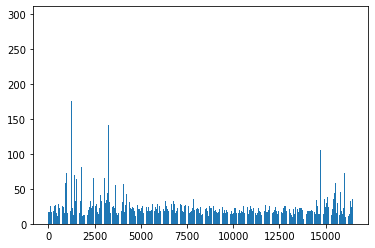

In [ ]:
# sentence length plot
y = [len(tokens) for tokens in tokenized_texts]
print('Median:', np.median(y))
x = range(len(tokenized_texts))

plt.bar(x, y)
plt.show()

In [ ]:
max_len = 40

Pad sequences

In [ ]:
# convert tokens to ids
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype='long', truncating='post', padding='post')

input_ids[0]

array([  101,  6548,  5632,  1348,  7864,  1105,  1682,  1106,  4321,
       10401,  1377,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])

In [ ]:
# convert labels to ids
tags = pad_sequences([[tag2idx[l] for l in label] for label in word_piece_labels],
                     maxlen=max_len, dtype='long', padding='post', truncating='post', 
                     value=tag2idx['[PAD]'])

tags[0]

array([2, 4, 4, 7, 4, 4, 1, 3, 3, 7, 7, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

Attention mask

In [ ]:
# Mask to avoid performing attention on padding token indices. 
# 1 for actual tokens, 0 for padded tokens.
attention_masks = [[int(i > 0) for i in ii] for ii in input_ids]

In [ ]:
# train test split
train_inputs, test_inputs, train_tags, test_tags, train_attn_masks, test_attn_masks = train_test_split(input_ids,
                                                                                                       tags,
                                                                                                       attention_masks,
                                                                                                       random_state=42,
                                                                                                       shuffle=True,
                                                                                                       test_size=0.2)

print('train:', len(train_inputs), len(train_tags), len(train_attn_masks))
print('test:', len(test_inputs), len(test_tags), len(test_attn_masks))

train: 13177 13177 13177
test: 3295 3295 3295


In [ ]:
# convert all to tensors
train_inputs = torch.tensor(train_inputs)
train_attn_masks = torch.tensor(train_attn_masks)
train_tags = torch.tensor(train_tags)

test_inputs = torch.tensor(test_inputs)
test_attn_masks = torch.tensor(test_attn_masks)
test_tags = torch.tensor(test_tags)

In [ ]:
print('train_inputs tensor:', train_inputs.shape)
print('train_attn_masks tensor:', train_attn_masks.shape)
print('train_tags tensor:', train_tags.shape)
print('\n')
print('test_inputs tensor:', test_inputs.shape)
print('test_attn_masks tensor:', test_attn_masks.shape)
print('test_tags tensor:', test_tags.shape)

train_inputs tensor: torch.Size([13177, 40])
train_attn_masks tensor: torch.Size([13177, 40])
train_tags tensor: torch.Size([13177, 40])


test_inputs tensor: torch.Size([3295, 40])
test_attn_masks tensor: torch.Size([3295, 40])
test_tags tensor: torch.Size([3295, 40])


In [ ]:
BATCH_SIZE = 32

In [ ]:
# only set token embedding, tag_embedding ,attention embedding, NO segment embedding
train_data = TensorDataset(train_inputs, train_attn_masks, train_tags)
train_sampler = RandomSampler(train_data)
# drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              sampler=train_sampler,
                              drop_last=True)

test_data = TensorDataset(test_inputs, test_attn_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, 
                              batch_size=BATCH_SIZE, 
                              sampler=test_sampler,)

## Train Model

Set up GPU environment

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
with open(os.path.join(drive_path, 'idx2tag.pkl'), 'rb') as p:
    idx2tag = pickle.load(p)

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', 
                                                   num_labels=len(idx2tag),
                                                   output_attentions = False,
                                                   output_hidden_states = False,)

In [ ]:
model.cuda();

Set fine-tuning method

In [ ]:
# True: fine tuning all the layers 
# False: only fine tuning the classifier layers
FULL_FINETUNING = True

if FULL_FINETUNING:
    # fine tune all layer parameters of the model
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
         ]
else:
    # only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
    
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

In [ ]:
# Set epoch and max_grad_norm (for gradient clipping)
epochs = 5
max_grad_norm = 1.0

# Cacluate train optimization num
num_train_optimization_steps = int(np.ceil(len(train_inputs) / BATCH_SIZE)) * epochs
num_train_optimization_steps

2060

Fine-tuning

In [ ]:
train_loss_values, val_loss_values = [], []

for epoch in range(epochs):
    # ========================================
    #               Training
    # ========================================
    model.train()

    train_loss = 0
    for batch in tqdm(train_dataloader, desc='Epoch ' + str(epoch)):
        batch = tuple(t.to(device) for t in batch)
        batch_inputs, batch_attn_masks, batch_tags = batch
        # always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        
        # forward pass
        outputs = model(batch_inputs, 
                        token_type_ids=None,
                        attention_mask=batch_attn_masks,
                        labels=batch_tags)
        loss = outputs[0]

        # backward pass
        loss.backward()

        # track train loss
        train_loss += loss.item()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

    # print average train_loss
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)
    print('Average train loss:', train_loss)

    # ========================================
    #               Validation
    # ========================================
    model.eval();

    eval_loss, eval_accuracy = 0, 0
    predictions , true_labels = [], []
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        batch_inputs, batch_attn_masks, batch_tags = batch

        with torch.no_grad():
            outputs = model(batch_inputs, 
                        token_type_ids=None,
                        attention_mask=batch_attn_masks,
                        labels=batch_tags)
        
        # CALC VAL LOSS
        eval_loss += outputs[0].mean().item()
        
        # CALC VAL ACC
        # get pred labels
        logits = outputs[1]
        logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        logits = logits.detach().cpu().numpy()

        # get true labels
        label_ids = batch_tags.to('cpu').numpy()

        # Only predict the real word, mark=0, will not calculate
        batch_attn_masks = batch_attn_masks.to('cpu').numpy()

        for i, mask in enumerate(batch_attn_masks):
            # Real one
            temp_1 = []
            # Predict one
            temp_2 = []
            
            for j, m in enumerate(mask):
                # Mark=0, meaning its a pad word, dont compare
                if m:
                    if idx2tag[label_ids[i][j]] != "X" and idx2tag[label_ids[i][j]] != "[CLS]" and idx2tag[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                        temp_1.append(idx2tag[label_ids[i][j]])
                        temp_2.append(idx2tag[logits[i][j]])
                else:
                    break
            true_labels.append(temp_1)
            predictions.append(temp_2)

    eval_loss = eval_loss / len(test_dataloader)
    val_loss_values.append(eval_loss)
    print('Validation loss:', eval_loss)
    print('Validation accuracy:' ,accuracy_score(true_labels, predictions))
    print('Validation f1 score:', f1_score(true_labels, predictions))

## Save Model

In [ ]:
# Save a trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

In [ ]:
model_dirname = 'trained_model_hs_ss_group_5epochs'
if not os.path.exists(model_dirname):
    os.makedirs(model_dirname)

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(model_dirname, "pytorch_model.bin")
output_config_file = os.path.join(model_dirname, "config.json")

In [ ]:
# Save model into file
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(model_dirname)

('trained_model_hs_ss_group_5epochs/vocab.txt',)

In [ ]:
! cp -r $model_dirname drive/My\ Drive/hackathons/ibm_hack_2020/$model_dirname

## Evaluation

In [ ]:
report = classification_report(true_labels, predictions, digits=4)
print('Clasification report:\n', report)

Clasification report:
            precision    recall  f1-score   support

hardskill     0.9323    0.9599    0.9459      5606
softskill     0.8383    0.8878    0.8623      1577

micro avg     0.9097    0.9440    0.9266      7183
macro avg     0.9116    0.9440    0.9275      7183



## Inference

In [ ]:
if LOAD_DATA:
    # load idx2tag
    with open(os.path.join(drive_path, 'idx2tag.pkl'), 'rb') as p:
        idx2tag = pickle.load(p)

    # load BERT tokenizer
    tokenizer=BertTokenizer.from_pretrained(os.path.join(drive_path, 'trained_model_hs_ss_group_5epochs'), do_lower_case=False)

    # load model
    model = BertForTokenClassification.from_pretrained(os.path.join(drive_path, 'trained_model_hs_ss_group_5epochs'), num_labels=len(idx2tag))

In [ ]:
# set up gpu environment
model.cuda();
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def predict(test_sentence):
    tokenized_sentence = tokenizer.encode(test_sentence)
    input_ids = torch.tensor([tokenized_sentence]).cuda()
    
    # predict
    model.eval();
    with torch.no_grad():
        outputs = model(input_ids)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_indices = np.argmax(logits[0], axis=-1)

    # join bpe split tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(idx2tag[label_idx])
            new_tokens.append(token)
    
    i = 0
    extracted = set()
    temp_skill = []
    for idx, tup in enumerate(zip(new_tokens, new_labels)):
        token, label = tup
        if 'skill' in label:
            if i == 0:
                temp_skill.append(token)
            else:
                if label.split('-')[0] == 'B':
                    extracted.add((' '.join(temp_skill), prev_tag.split('-')[1]))
                    temp_skill = []
                    temp_skill.append(token)
                else:
                    temp_skill.append(token)
            prev_tag = label
            i += 1
        elif ' '.join(temp_skill) not in extracted and idx == len(new_tokens) - 1:
            extracted.add((' '.join(temp_skill), prev_tag.split('-')[1]))

    return extracted

In [ ]:
skills = predict('I have good time management skills.')
skills

{('time management', 'softskill')}